# Breast Cancer prediction from Ultrasound images

In [1]:
# # import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#callbacks

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint('./output', monitor='val_loss', save_best_only=True, mode='min')
]

In [3]:
# 2 layer CNN

In [21]:
# Initialising the CNN
tumor_classifier = Sequential()

# Convolution
tumor_classifier.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))

# Step 2 - Pooling
tumor_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
tumor_classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

tumor_classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Flattening
tumor_classifier.add(Flatten())

# CNN network
tumor_classifier.add(Dense(units = 1024, activation = 'relu'))
tumor_classifier.add(Dense(units = 512, activation = 'relu'))
tumor_classifier.add(Dense(units = 3, activation = 'softmax'))

# Compiling the CNN
tumor_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy','AUC'])

In [17]:
import glob
train_sample_size = len(glob.glob('US_DL/Train/*/*.png'))
test_sample_size = len(glob.glob('US_DL/Test/*/*.png'))
train_sample_size, test_sample_size


(556, 224)

In [22]:
# Fitting the CNN to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1/255.)

training_set = train_datagen.flow_from_directory('US_DL/Train',
                                                 target_size = (256, 256),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory('US_DL/Test',
                                            target_size = (256, 256),
                                            batch_size = 10,
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                            shuffle=True)
                     
batch_size=10

tumor_classifier.fit_generator(training_set,
                         steps_per_epoch = train_sample_size//batch_size,
                         epochs = 20,
                         validation_data = test_set,
                         validation_steps = test_sample_size//batch_size,
                               callbacks=keras_callbacks)

Found 556 images belonging to 3 classes.
Found 224 images belonging to 3 classes.
Epoch 1/20
55/55 [==============================] - 175s 3s/step - loss: 2.8566 - accuracy: 0.5219 - auc: 0.6462 - val_loss: 0.9357 - val_accuracy: 0.5909 - val_auc: 0.7662
Epoch 2/20
55/55 [==============================] - 169s 3s/step - loss: 0.9296 - accuracy: 0.6005 - auc: 0.7547 - val_loss: 0.9012 - val_accuracy: 0.5682 - val_auc: 0.7719
Epoch 3/20
55/55 [==============================] - 116s 2s/step - loss: 0.9363 - accuracy: 0.6036 - auc: 0.7515 - val_loss: 0.8487 - val_accuracy: 0.6227 - val_auc: 0.8018
Epoch 4/20
55/55 [==============================] - 107s 2s/step - loss: 0.8160 - accuracy: 0.6534 - auc: 0.8103 - val_loss: 0.8164 - val_accuracy: 0.6273 - val_auc: 0.8155
Epoch 5/20
55/55 [==============================] - 140s 3s/step - loss: 0.7348 - accuracy: 0.6945 - auc: 0.8563 - val_loss: 0.8308 - val_accuracy: 0.6000 - val_auc: 0.8151
Epoch 6/20
55/55 [==============================] - 1

In [23]:
#save model
tumor_classifier.save('CNN2L_US_BC.h5') # creates a HDF5 file ‘my_model.h5’

In [24]:
test_generator = ImageDataGenerator()
test_dataset = test_generator.flow_from_directory('US_DL/Test',
                                            target_size = (256, 256),
                                            batch_size = 10,
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                                         shuffle=False)

test_steps_per_epoch = np.math.ceil(test_dataset.samples / test_dataset.batch_size)

predictions = tumor_classifier.predict_generator(test_dataset, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 224 images belonging to 3 classes.


In [37]:
#take true labels
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys()) 
class_labels
test_dataset.class_indices

['benign', 'malignant', 'normal']

{'benign': 0, 'malignant': 1, 'normal': 2}

              precision    recall  f1-score   support

      benign       0.59      0.95      0.73       124
   malignant       0.86      0.30      0.44        61
      normal       0.25      0.03      0.05        39

    accuracy                           0.61       224
   macro avg       0.57      0.42      0.41       224
weighted avg       0.61      0.61      0.53       224



<Figure size 600x600 with 0 Axes>

Text(16.44444444444444, 0.5, 'True Classes')

Text(0.5, 16.444444444444446, 'Predicted Classes')

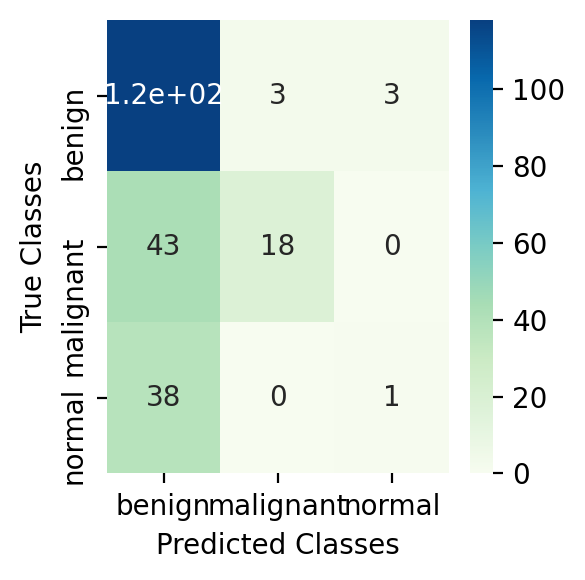

In [66]:
#evaluation of model using confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 
plt.figure(figsize=(3,3),dpi=200)
sb.heatmap(confusion_matrix(true_classes, predicted_classes),annot=True,cmap='GnBu',xticklabels=class_labels,
           yticklabels=class_labels)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.tight_layout()
plt.savefig('CM_US_CNN_whole.png')
plt.show()

In [62]:
#identify correct and wrong predictions per image
df_pred=pd.DataFrame(columns=['Image','Actual','Predicted'])
df_pred['Image']=test_dataset.filenames
df_pred['Actual']=test_dataset.classes
df_pred['Predicted']=predicted_classes
rep_dict={v:k for k, v in test_dataset.class_indices.items()}
df_pred.Actual.replace(rep_dict,inplace=True)
df_pred.Predicted.replace(rep_dict,inplace=True)

In [63]:
df_pred

,Image,Actual,Predicted
0,benign/benign (1).png,benign,benign
1,benign/benign (106).png,benign,benign
2,benign/benign (107).png,benign,benign
3,benign/benign (110).png,benign,benign
4,benign/benign (111).png,benign,benign
...,...,...,...
219,normal/normal (9).png,normal,benign
220,normal/normal (92).png,normal,benign
221,normal/normal (93).png,normal,benign
222,normal/normal (94).png,normal,benign


(1, 256, 256, 1)
{'benign': 0, 'malignant': 1, 'normal': 2}
The test image is belongs to the class:  1.0


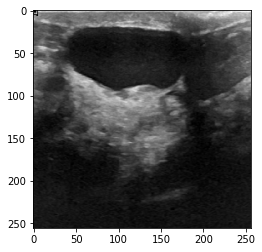

In [30]:
#model example prediction
from tensorflow.keras.models import load_model
mymodel = load_model('CNN2L_US_BC.h5')
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('US_DL/Test/benign/benign (110).png', target_size = (256, 256),grayscale=True)
plt.imshow(test_image,cmap='gray')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
print(test_image.shape)
print(training_set.class_indices)
result = mymodel.predict(test_image)
print('The test image is belongs to the class: ',result[0][0])

(1, 256, 256, 1)
{'benign': 0, 'malignant': 1, 'normal': 2}
The test image is belongs to the class:  0.0


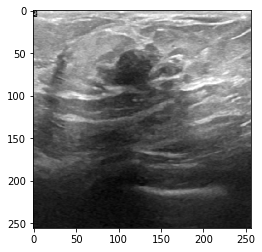

In [31]:
#malignant example
test_image = image.load_img('US_DL/Test/malignant/malignant (100).png', target_size = (256, 256),grayscale=True)
plt.imshow(test_image,cmap='gray')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
print(test_image.shape)
print(training_set.class_indices)
result = mymodel.predict(test_image)
print('The test image is belongs to the class: ',result[0][0])

(1, 256, 256, 1)
{'benign': 0, 'malignant': 1, 'normal': 2}
The test image is belongs to the class:  1.0


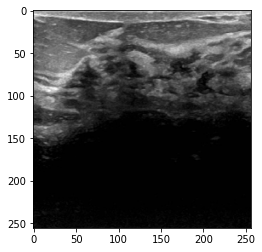

In [32]:
#normal example
test_image = image.load_img('US_DL/Test/normal/normal (10).png', target_size = (256, 256),grayscale=True)
plt.imshow(test_image,cmap='gray')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
print(test_image.shape)
print(training_set.class_indices)
result = mymodel.predict(test_image)
print('The test image is belongs to the class: ',result[0][0])

### When you use whole image minor classes are not predicted. This is because of having smaller size for malignant and normal cases
### To improve model one can use ground truth or mask image which will have distinctive shape of tumor region extracted.


Image segmentation extracting features are important to correctly identify tumor type using deep learning frameworks when data set is small.
Machine learning approaches for extracted features 